In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt

In [ ]:
from transformers import BertTokenizer, TFBertModel
from keras.models import load_model
from keras.models import Model

In [ ]:
# run on google colab
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128

def tokenize_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf')

tokenized_texts = [tokenize_text(text) for text in df['content']]



In [ ]:
# Load pre-trained BERT model and extract the last layer as features 
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


bert_text_representations = []
for tokenized_text in tokenized_texts:
    output = bert_model(tokenized_text)
    text_representation = tf.reduce_mean(output.last_hidden_state, axis=1).numpy()
    bert_text_representations.append(text_representation)

bert_text_representations = np.concatenate(bert_text_representations, axis=0)

In [5]:
df = pd.read_csv('C:/Users/tsong/Downloads/bert_google_vision.csv',index_col = 0)

In [6]:
df.fillna(0, inplace = True)

In [35]:
list(df.columns).index('bert_0')

827

In [8]:
X = df.iloc[:,827:]
print(X.shape)

pca = PCA(n_components=101)
X_pca = pca.fit_transform(X)

(1000, 768)


<Axes: >

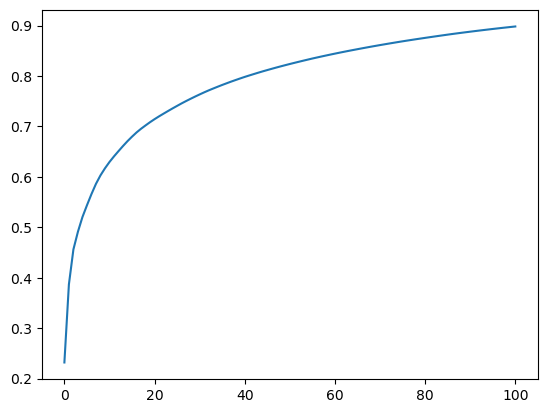

In [53]:
pd.Series(np.cumsum(pca.explained_variance_ratio_)).plot()

In [38]:
np.argmax(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9,1,0))

101

In [7]:
X_pca.shape

(1000, 101)

In [14]:
svd = TruncatedSVD(n_components=200)  # Choose the number of components as needed
X_svd = svd.fit_transform(df.iloc[:,4:828])

<Axes: >

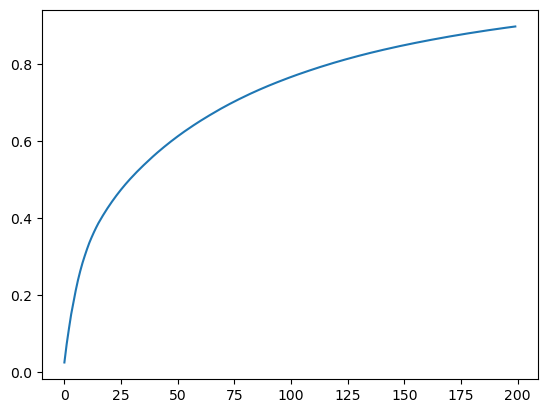

In [55]:
pd.Series( svd.explained_variance_ratio_.cumsum()).plot()

In [80]:
X = np.concatenate([X_svd,df.iloc[:,827:]],axis = 1)
# X = np.concatenate([X_svd,X_pca],axis = 1)

In [77]:
X.shape

(1000, 301)

In [28]:

y = df['comments']

## Regression (predicting # comments)

In [34]:
df['like'] = df['like'].replace(-1,0)
df['target'] = np.where(df['like']>500000,1,0)

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler


In [30]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)


# In-sample testing with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

regressor =  KNeighborsRegressor(n_neighbors=5)
regressor.fit(X_train, y_train)


in_sample_predictions = regressor.predict(X_test)
in_sample_mae = mean_absolute_error(y_test, in_sample_predictions)
in_mape = mean_absolute_percentage_error(y_test, in_sample_predictions)

print("In-sample MAE:", in_sample_mae)
print("In-sample MAPE:", in_mape)


cv_maes = []
cv_mape = []

for i in range(100):
    kf = KFold(n_splits=5, shuffle=True, random_state=i)  # Shuffle with different random_state each iteration
    fold_maes = []
    fold_mapes = []
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X[train_index,:], X[test_index,:]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        regressor_cv = KNeighborsRegressor(n_neighbors=5)
        regressor_cv.fit(X_train_cv, y_train_cv)
        
        cv_predictions = regressor_cv.predict(X_test_cv)
        fold_mae = mean_absolute_error(y_test_cv, cv_predictions)
        fold_mape = mean_absolute_percentage_error(y_test_cv, cv_predictions)
        fold_maes.append(fold_mae)
        fold_mapes.append(fold_mape)

    cv_maes.append(np.mean(fold_maes))
    cv_mape.append(np.mean(fold_mapes))

mean_cv_mae = np.mean(cv_maes)
std_cv_mae = np.std(cv_maes)

mean_cv_mape = np.mean(cv_mape)
std_cv_mape = np.std(cv_mape)

print("Mean out-of-sample MAE:", mean_cv_mae)
print("Standard deviation of out-of-sample MAE:", std_cv_mae)

print("Mean out-of-sample MAPE:", mean_cv_mape)
print("Standard deviation of out-of-sample MAPE:", std_cv_mape)

In-sample MAE: 1327.265
In-sample MAPE: 9970969574998288.0
Mean out-of-sample MAE: 1634.2224120000005
Standard deviation of out-of-sample MAE: 40.24468627317473
Mean out-of-sample MAPE: 1.3669397646588982e+16
Standard deviation of out-of-sample MAPE: 2322077775394124.5


## Binary Classification (Predict most liked posts)

In [36]:
y = df['target']

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score, average_precision_score, accuracy_score

In [41]:
y.value_counts()

target
0    901
1     99
Name: count, dtype: int64

In [81]:
# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# In-sample testing
knn_classifier.fit( X, y)
predicted_labels_in_sample = knn_classifier.predict(X)

# Calculate evaluation metrics for in-sample testing
recall_in_sample = recall_score(y, predicted_labels_in_sample)
average_precision_in_sample = average_precision_score(y, predicted_labels_in_sample)
accuracy_in_sample = accuracy_score(y, predicted_labels_in_sample)

print("In-sample Recall:", recall_in_sample)
print("In-sample Average Precision:", average_precision_in_sample)
print("In-sample Accuracy:", accuracy_in_sample)

# Out-of-sample testing with 100 random cross-validations
recall_out_of_sample = []
average_precision_out_of_sample = []
accuracy_out_of_sample = []

knn_classifier = KNeighborsClassifier(n_neighbors=5)

for i in range(100):
    predicted_labels_out_of_sample = cross_val_predict(knn_classifier, X, y, cv=5)
    recall_out_of_sample.append(recall_score(y, predicted_labels_out_of_sample))
    average_precision_out_of_sample.append(average_precision_score(y, predicted_labels_out_of_sample))
    accuracy_out_of_sample.append(accuracy_score(y, predicted_labels_out_of_sample))

mean_recall_out_of_sample = np.mean(recall_out_of_sample)
mean_average_precision_out_of_sample = np.mean(average_precision_out_of_sample)
mean_accuracy_out_of_sample = np.mean(accuracy_out_of_sample)

print("Mean Out-of-sample Recall:", mean_recall_out_of_sample)
print("Mean Out-of-sample Average Precision:", mean_average_precision_out_of_sample)
print("Mean Out-of-sample Accuracy:", mean_accuracy_out_of_sample)


In-sample Recall: 0.4444444444444444
In-sample Average Precision: 0.4624074074074074
In-sample Accuracy: 0.941
Mean Out-of-sample Recall: 0.25252525252525254
Mean Out-of-sample Average Precision: 0.2844377104377105
Mean Out-of-sample Accuracy: 0.9210000000000003


In [82]:
# Logistic Regression
classifier = LogisticRegression(C= 1, penalty = 'l2')
# In-sample testing
classifier.fit( X, y)
predicted_labels_in_sample = classifier.predict(X)

# Calculate evaluation metrics for in-sample testing
recall_in_sample = recall_score(y, predicted_labels_in_sample)
average_precision_in_sample = average_precision_score(y, predicted_labels_in_sample)
accuracy_in_sample = accuracy_score(y, predicted_labels_in_sample)

print("In-sample Recall:", recall_in_sample)
print("In-sample Average Precision:", average_precision_in_sample)
print("In-sample Accuracy:", accuracy_in_sample)

recall_out_of_sample = []
average_precision_out_of_sample = []
accuracy_out_of_sample = []


classifier = LogisticRegression(C= 1, penalty = 'l2')

for i in range(100):
    predicted_labels_out_of_sample = cross_val_predict(classifier, X, y, cv=5)
    recall_out_of_sample.append(recall_score(y, predicted_labels_out_of_sample))
    average_precision_out_of_sample.append(average_precision_score(y, predicted_labels_out_of_sample))
    accuracy_out_of_sample.append(accuracy_score(y, predicted_labels_out_of_sample))

mean_recall_out_of_sample = np.mean(recall_out_of_sample)
mean_average_precision_out_of_sample = np.mean(average_precision_out_of_sample)
mean_accuracy_out_of_sample = np.mean(accuracy_out_of_sample)

print("Mean Out-of-sample Recall:", mean_recall_out_of_sample)
print("Mean Out-of-sample Average Precision:", mean_average_precision_out_of_sample)
print("Mean Out-of-sample Accuracy:", mean_accuracy_out_of_sample)


In-sample Recall: 1.0
In-sample Average Precision: 1.0
In-sample Accuracy: 1.0
Mean Out-of-sample Recall: 0.9696969696969694
Mean Out-of-sample Average Precision: 0.9726969696969695
Mean Out-of-sample Accuracy: 0.997
